**Duc Nguyen**

# Translocation Analysis

The goal of this assignment is to:
- examine where translocations occur genome-wide
- quantify the level of enrichment

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 0. Preprocess

In [2]:
# load the tsv file
df = pd.read_csv("RF204_Alt055.tlx", delimiter="\t")
df

,Qname,Rname,Junction,Strand,Rstart,Rend,B_Rname,B_Rstart,B_Rend,B_Strand,B_Qstart,B_Qend,Qstart,Qend,Qlen,Seq,J_Seq
0,M01407:49:000000000-A7CDB:1:2109:6155:16526,chr1,10083,1,10083,10229,chr11,36594883,36595029,-1,3,149,163,311,335.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,taaccctaaccctaacccta
1,M01407:49:000000000-A7CDB:1:2108:13218:28605,chr1,10117,1,10117,10209,chr11,36594877,36595029,-1,3,155,158,251,NaN,TGGAGAGGGTTTCCCCTCAAAGGAATACTTCTTTTCCTTTTGAGCT...,ccaaccctaaccctaaccct
2,M01407:49:000000000-A7CDB:1:2103:6761:8534,chr1,10123,1,10123,10214,chr11,36594877,36595029,-1,3,155,158,245,NaN,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,ctaaccctaaccctaaccct
3,M01407:49:000000000-A7CDB:1:2111:23575:24144,chr1,10140,1,10140,10256,chr11,36594896,36595029,-1,3,136,137,251,NaN,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,cctaaccctaaccctaaccc
4,M01407:49:000000000-A7CDB:1:1104:9047:15418,chr1,10154,1,10154,10248,chr11,36594881,36595029,-1,3,151,149,240,337.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,taacccctaaccctaaccct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28547,M01407:49:000000000-A7CDB:1:2113:14748:17996,chrY,58991491,1,58991491,58991600,chr11,36594877,36595029,-1,3,155,189,298,323.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,ctgcctgcagtggcattgtg
28548,M01407:49:000000000-A7CDB:1:1114:20957:12350,chrY,58995345,-1,58995280,58995345,chr11,36594892,36595029,-1,3,140,140,205,223.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,gtatctctgcaatgatcaat
28549,M01407:49:000000000-A7CDB:1:1101:20541:23758,chrY,59028748,-1,59028699,59028748,chr11,36594893,36595029,-1,3,139,138,187,206.0,TGGAGAGGGTTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,TATATCTGTGAACAGCAGTG
28550,M01407:49:000000000-A7CDB:1:2105:8746:18201,chrY,59363328,-1,59363218,59363328,chr11,36594889,36595029,-1,3,143,141,251,NaN,TGGAGAGGGGTTCCCCTCAAAGGAATCCTTCTTTTCCTTTTGAGCT...,ggttagggttagggttaggg


In [3]:
# check the integrity of Junction column
# if Strand = 1, Junction = Rstart; if Stran = -1, Junction = Rend
print(np.sum(df[df['Junction']==df['Rstart']]['Strand']==-1))
print(np.sum(df[df['Junction']==df['Rend']]['Strand']==1))

0
0


In [4]:
# check NA values
print(np.sum((df.isna())))
# All NA values are in the query length column

Qname         0
Rname         0
Junction      0
Strand        0
Rstart        0
Rend          0
B_Rname       0
B_Rstart      0
B_Rend        0
B_Strand      0
B_Qstart      0
B_Qend        0
Qstart        0
Qend          0
Qlen        720
Seq           0
J_Seq         0
dtype: int64


In [5]:
# load chromosome names and lengths
chromosomes = pd.read_csv('ChromInfo.txt', delimiter='\t', header=None)
chromosomes = chromosomes.set_index(0).T.to_dict('index')[1]
chromosomes

{'chr1': 249250621,
 'chr10': 135534747,
 'chr11': 135006516,
 'chr12': 133851895,
 'chr13': 115169878,
 'chr14': 107349540,
 'chr15': 102531392,
 'chr16': 90354753,
 'chr17': 81195210,
 'chr18': 78077248,
 'chr19': 59128983,
 'chr2': 243199373,
 'chr20': 63025520,
 'chr21': 48129895,
 'chr22': 51304566,
 'chr3': 198022430,
 'chr4': 191154276,
 'chr5': 180915260,
 'chr6': 171115067,
 'chr7': 159138663,
 'chr8': 146364022,
 'chr9': 141213431,
 'chrM': 16571,
 'chrX': 155270560,
 'chrY': 59373566}

### 1. Naive approach: Bin count

We divide each chromosomes into bins along its length, then count the number of translocations appearing in each bin. It is possible since the maximum length of translocations ($Rend - Rstart$) is 1433, and the mean is 115 bases, whcih are very small compared to the chromosomes' length. Therefore, the possibility that a translocation stretches along two adjacent bins are very low.

In [6]:
(df['Rend']-df['Rstart']).describe()

count    28552.000000
mean       140.422142
std        103.039651
min         24.000000
25%         66.000000
50%        115.000000
75%        189.000000
max       1433.000000
dtype: float64

Below, we choose a bin size of 1 Mb, and ignore any zero bin counts (no translocations).

In [7]:
bin_size=1000000
newdf = df.copy(deep=True)
newdf['bin'] = newdf['Junction'] // bin_size
bin_counts = pd.DataFrame(columns = ['Chrom', 'Bin', 'Count', 'Start', 'End'])

for chrom_name, chrom_length in chromosomes.items():
    chrom_df = newdf[newdf['Rname'] == chrom_name]
    bins = chrom_df.groupby('bin').groups.keys()
    counts = chrom_df.groupby('bin')['Qname'].count()

    chrom_count_df = pd.DataFrame({'Chrom': chrom_name, 'Bin': bins, 'Count': counts})
    chrom_count_df['Start'] = chrom_count_df['Bin']*bin_size
    chrom_count_df['End'] = np.where((chrom_count_df['Bin']+1)*bin_size <= chrom_length,
                                     (chrom_count_df['Bin']+1)*bin_size, chrom_length)
    bin_counts = pd.concat([bin_counts, chrom_count_df])

bin_counts.tail(20)

,Chrom,Bin,Count,Start,End
144,chrX,144,7,144000000,145000000
145,chrX,145,5,145000000,146000000
146,chrX,146,4,146000000,147000000
147,chrX,147,2,147000000,148000000
148,chrX,148,5,148000000,149000000
149,chrX,149,9,149000000,150000000
150,chrX,150,4,150000000,151000000
151,chrX,151,7,151000000,152000000
152,chrX,152,4,152000000,153000000
153,chrX,153,13,153000000,154000000


In [8]:
# summary statistics
max_depth = bin_counts['Count'].max()
min_depth = bin_counts['Count'].min()
print(f'Total genome length: {sum(list(chromosomes.values()))}')
print('Total bins:', bin_counts['Bin'].count())
print('Total translocations:', bin_counts['Count'].sum())
print('Maximal count: ', max_depth, '(', ",".join(bin_counts[bin_counts['Count'] == max_depth]['Chrom'].unique()), ')')
print('Minimal count: ', min_depth, '(', ",".join(bin_counts[bin_counts['Count'] == min_depth]['Chrom'].unique()), ')')
print('Average count: ', round(bin_counts['Count'].mean(), 2))

Total genome length: 3095693983
Total bins: 2853
Total translocations: 28552
Maximal count:  5403 ( chr11 )
Minimal count:  1 ( chr1,chr10,chr12,chr13,chr14,chr15,chr16,chr18,chr19,chr2,chr20,chr22,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chrX,chrY )
Average count:  10.01


In [9]:
# statistics per chromosome
for chrom_name, chrom_length in chromosomes.items():
    chrom_df = bin_counts[bin_counts['Chrom'] == chrom_name]
    print(f'{chrom_name}')
    print(f'\tLength: {chrom_length}')
    print('\tBin: ', chrom_df['Chrom'].count())
    print('\tTranslocation: ', chrom_df['Count'].sum())
    print('\tMaximal count: ', chrom_df['Count'].max())
    print('\tMinimal count: ', chrom_df['Count'].min())
    print('\tAverage count: ', chrom_df['Count'].mean())
    

chr1
	Length: 249250621
	Bin:  228
	Translocation:  2150
	Maximal count:  50
	Minimal count:  1
	Average count:  9.429824561403509
chr10
	Length: 135534747
	Bin:  134
	Translocation:  977
	Maximal count:  22
	Minimal count:  1
	Average count:  7.291044776119403
chr11
	Length: 135006516
	Bin:  133
	Translocation:  7919
	Maximal count:  5403
	Minimal count:  3
	Average count:  59.54135338345865
chr12
	Length: 133851895
	Bin:  132
	Translocation:  1062
	Maximal count:  177
	Minimal count:  1
	Average count:  8.045454545454545
chr13
	Length: 115169878
	Bin:  96
	Translocation:  869
	Maximal count:  32
	Minimal count:  1
	Average count:  9.052083333333334
chr14
	Length: 107349540
	Bin:  89
	Translocation:  635
	Maximal count:  75
	Minimal count:  1
	Average count:  7.134831460674158
chr15
	Length: 102531392
	Bin:  79
	Translocation:  841
	Maximal count:  255
	Minimal count:  1
	Average count:  10.645569620253164
chr16
	Length: 90354753
	Bin:  81
	Translocation:  617
	Maximal count:  28
	Min

We export the Chromosome, Start, End, and Count into a bedGraph file.

In [10]:
if not os.path.exists('bin_count'):
    os.mkdir('bin_count')
bin_counts[['Chrom', 'Start', 'End', 'Count']].to_csv(f'bin_count/bin_count_{bin_size//1000000}Mb.bg', sep="\t", index=False, header=False)

Next, we visualize the frequency of genome-wide translocations using Matplotlib, and export into a PDF file for higher resolution.

In [11]:
color_map = {
        2000: 'purple',
        500: 'blue',
        100:'green',
        20:'orange',
        5: 'red',
        1: 'black'
    }

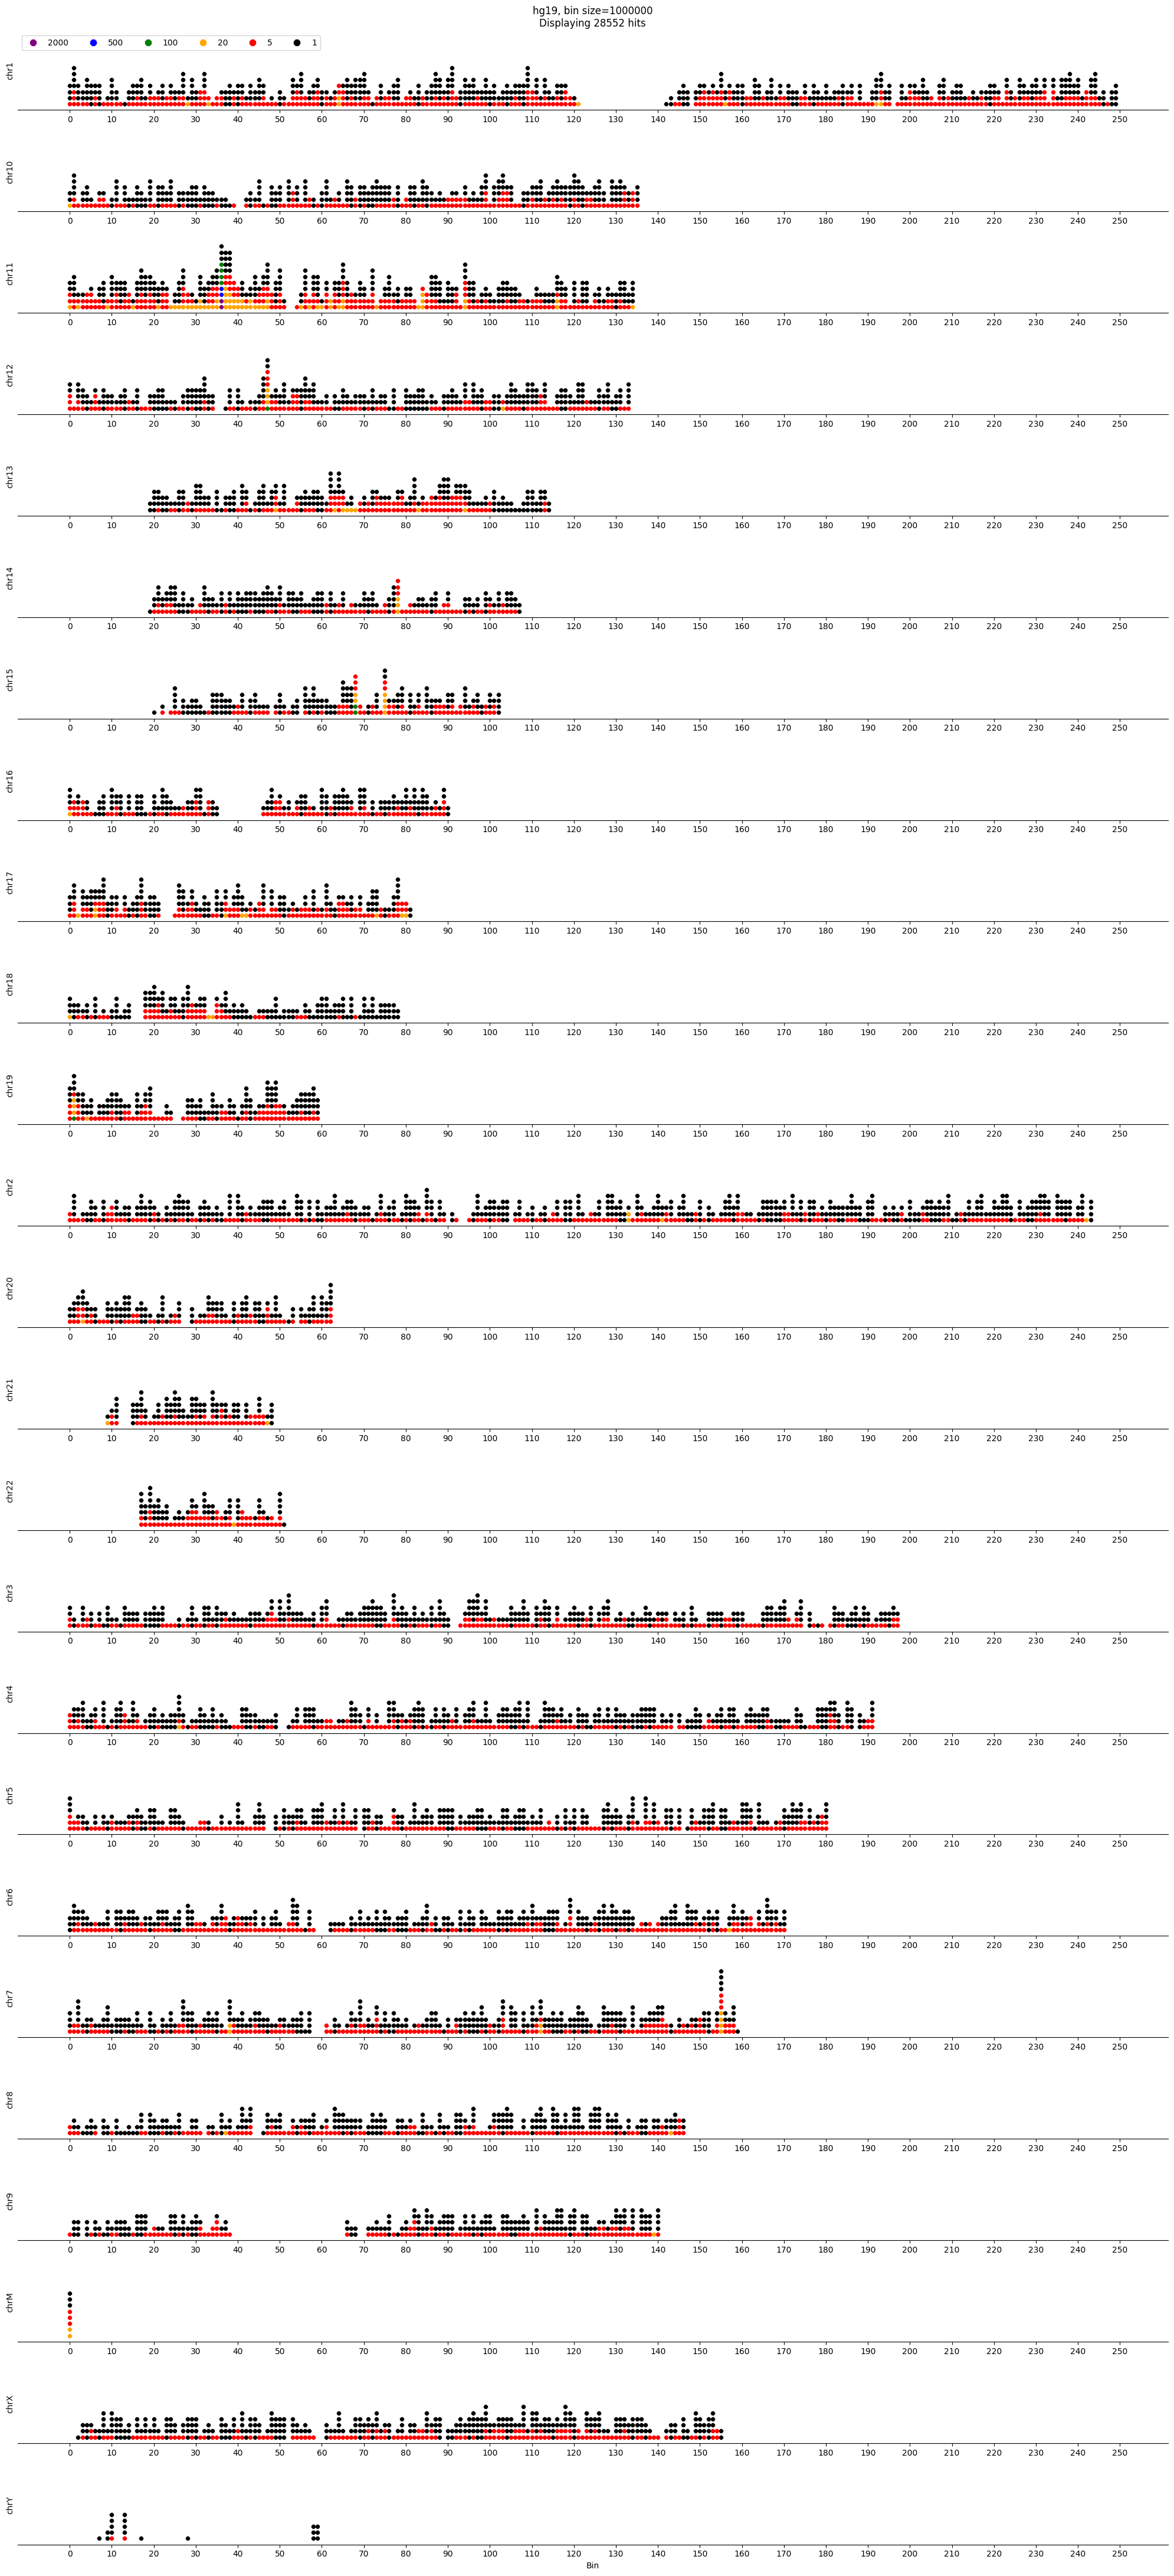

In [12]:
import matplotlib.lines as lines

def dot_plot_splitv2(data, color_map, chromosomes, title="Hit map", bin_size=1000000):
    
    # divide the raw count into small chunks
    def display_count(frequency, max_values):
        display_count=[]
        for max_val in max_values:
            display_count.append(frequency//max_val)
            frequency = frequency%max_val
        return display_count

    # dotplot
    fig, axes = plt.subplots(len(chromosomes), 1, sharex=True, figsize=(20, 1.75*len(chromosomes)))
    for index, (chrom_name, chrom_length) in enumerate(chromosomes.items()):
        
        sub_data = data[data['Chrom'] == chrom_name][['Bin', 'Count']]
        sub_data = np.array(sub_data)
        for value, freq in zip(sub_data[:,0], sub_data[:,1]):    
            display_counts = display_count(freq, color_map)
            for i, count in enumerate(display_counts):
                axes[index].plot([value]*count, list(range(sum(display_counts[:i]), sum(display_counts[:(i+1)]))), 
                        '8', ms=4.5, linestyle='', c=list(color_map.values())[i])
        
        # show y-axis labels and ticks
        for spine in ['top', 'left', 'right']:
            axes[index].spines[spine].set_visible(False)
        axes[index].set_ylim(-1, 12)
        axes[index].set_yticks([])
        axes[index].set_ylabel(chrom_name)
        axes[index].xaxis.set_tick_params(which='both', labelbottom=True)
    
    # # show x-axis and title
    axes[0].set_title(title)
    axes[-1].set_xticks(np.arange(0, math.ceil(max(chromosomes.values())//bin_size)+2, 10))
    axes[-1].set_xlabel('Bin')
    
    # legend
    symbols = []
    for max_val, color in color_map.items():
        symbols.append(lines.Line2D([], [], color=color, marker='8', linestyle='None',
                        ms=8, label=max_val))
    axes[0].legend(handles=symbols, loc='upper left', ncol = 6)
    
    plt.tight_layout()
    plt.savefig(f'bin_count/bin_count_{bin_size//1000000}Mb_plot.pdf')

input_data = bin_counts[['Chrom', 'Bin', 'Count']]
display_hit_count = bin_counts['Count'].sum()
dot_plot_splitv2(input_data, color_map, chromosomes, f'hg19, bin size={bin_size}\nDisplaying {display_hit_count} hits', bin_size)

A large concentration of translocations (count = 5403) occurs at the 36th bin (36,000,000-37,000,000) on chromosome 11.
Small numbers of translocations (count > 100) are also observed at 68th bin on chromosome 15, 47th bin on chromosome 12, and 1st bin on chromosome 19.

We continue examining the hotspot on chromosome 11 below.

In [34]:
hotpots = newdf[(newdf['Rname']  == 'chr11') & (newdf['bin'] == 36)]
hotpots['Junction'].describe()

count    5.403000e+03
mean     3.659547e+07
std      4.330433e+04
min      3.601839e+07
25%      3.659380e+07
50%      3.659484e+07
75%      3.659662e+07
max      3.699800e+07
Name: Junction, dtype: float64

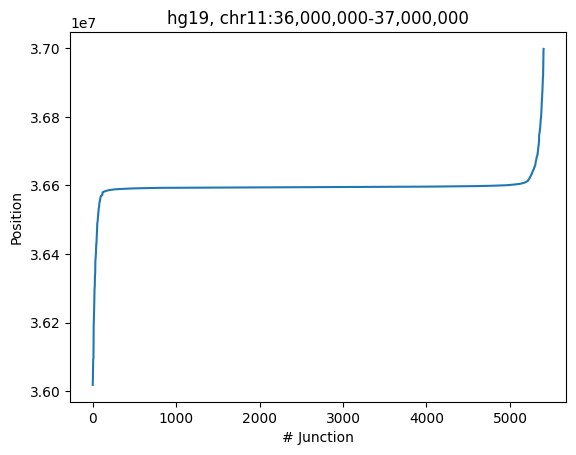

In [36]:
plt.plot(np.arange(1, hotpots['Junction'].count()+1), hotpots['Junction'])
plt.xlabel('# Junction')
plt.ylabel('Position')
plt.title('hg19, chr11:36,000,000-37,000,000')
plt.show()

We notice that a majority of translocations in this 1Mb bin concentrates within 2000 bases around chr11:36,594,840.

Further analysis based on chromosome sequences and/or intron/exon among these sites should be perform, but we do not have enough contexts of the given data to do so.

### 2. Less naive approach: Genome coverage with `BEDTools`

Although binning gives us a pretty good idea of where the translocations occur, the lost of information will lead to bias. Since the binning range is 1 Mb, it is difficult to tell whether translocations within one bin are grouped together or not. Also, since the lengths of chromosomes are very diverse, a universal bin size might not work well on very long/very short one, e.g. mitochondrial DNA.

`BEDTools` allows us to measure the genome-wide coverage of certain features on each bases. We need both the start coordinates and end coordinates though, so we will assume that the translocations stretch from `Rstart` to `Rend` or vice versa, instead of occur at a single junction point.


### Reference

Aaron R. Quinlan, Ira M. Hall, BEDTools: a flexible suite of utilities for comparing genomic features, Bioinformatics, Volume 26, Issue 6, March 2010, Pages 841–842, https://doi.org/10.1093/bioinformatics/btq033